## Dependencies

In [1]:
#Import dependencies

#NFL pbp data
import nfl_data_py as nfl

#Basics / visualizations
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#Machine learning tools
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#Stats Stuff
from scipy import stats
from scipy.stats import t
from scipy.stats import truncnorm

#Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)

#Turn off when showing off, switch comments to change
pd.options.mode.chained_assignment = None  # Disable the warning
# pd.options.mode.chained_assignment = 'warn'

## Importing and Prepping Schedules

In [2]:
schedules_df = nfl.import_schedules([2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

In [3]:
def calculate_implied_totals(df):
    """
    Calculate the implied home and away team totals based on the spread and total lines.
    """
    #Implied totals based on the total and spread lines
    df['implied_home_total'] = (df['total_line'] + df['spread_line']) / 2
    df['implied_away_total'] = (df['total_line'] - df['spread_line']) / 2
    
    return df

In [4]:
schedules_df = calculate_implied_totals(schedules_df)

In [5]:
schedules_df.drop(columns= ['away_coach', 'home_coach', 'referee',
       'stadium_id', 'stadium', 'away_score', 'home_score',
       'location', 'result', 'total', 'overtime', 'old_game_id', 'gsis',
       'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'away_rest', 'home_rest',
       'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds',
       'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game', 'away_qb_id', 'home_qb_id', 'gameday', 'weekday',
       'gametime'], inplace=True)

In [6]:
#Create a DataFrame for away quarterbacks
away_df = schedules_df[['game_id', 'season', 'game_type', 'week', 'away_team', 'home_team', 'away_qb_name', 'implied_away_total', 'roof', 'surface',]].copy()
away_df.rename(columns={'away_qb_name': 'qb_name', 'implied_away_total': 'implied_total'}, inplace=True)
away_df['home_away'] = 'away'
away_df['posteam'] = away_df['away_team']
away_df['defteam'] = away_df['home_team']

#Create a DataFrame for home quarterbacks
home_df = schedules_df[['game_id', 'season', 'game_type', 'week', 'away_team', 'home_team', 'home_qb_name', 'implied_home_total', 'roof', 'surface']].copy()
home_df.rename(columns={'home_qb_name': 'qb_name', 'implied_home_total': 'implied_total'}, inplace=True)
home_df['home_away'] = 'home'
home_df['posteam'] = home_df['home_team']
home_df['defteam'] = home_df['away_team']

#Concatenate both DataFrames
combined_schedule_df = pd.concat([away_df, home_df])

#Reset index for cleanliness
combined_schedule_df.reset_index(drop=True, inplace=True)

In [7]:
def format_passer_name(qb_name):
    if pd.isna(qb_name):  #Check if the name is NaN
        return ""
    
    name_parts = qb_name.split()
    
    #Extract the first name and last name
    first_name = name_parts[0]
    last_name = name_parts[-1]  # Last name should always be the last part
    
    return f"{first_name[0]}.{last_name}"

#Apply the function to create the new 'player_passer_name' column
combined_schedule_df['passer_player_name'] = combined_schedule_df['qb_name'].apply(format_passer_name)

In [8]:
#Reorder Columns
combined_schedule_df = combined_schedule_df[['game_id', 'season', 'game_type', 'week', 'roof', 'surface',
                                             'posteam', 'defteam', 'home_team', 'away_team', 'implied_total', 'home_away']]

## Importing PBP Training Data

In [9]:
#Select only the relevant columns
columns = ['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards', 
           'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
           'passing_yards', 'cpoe', 'roof', 'surface']

#Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2014,2024 + 1), columns, include_participation=False)

#nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
data = data[columns]

#Drop all rows that are not a pass
data = data[data['play_type'] == 'pass']

#Drop the play type column
passer_data = data.drop(columns=['play_type'])

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


## Passer DF Training Prep

In [10]:
# passer_data.columns

In [11]:
#Group the data together by passer, week, season and aggregate
passer_df = passer_data.groupby(['game_id', 'posteam', 'week', 'season'], as_index=False).agg(
    {
     'defteam' : 'first',
     'passer_player_name' : 'first',
     'home_team' : 'first',
     'away_team' : 'first',
     'air_yards' : 'sum',
     'yards_after_catch' : 'sum',
     'epa' : 'sum',
     'complete_pass' : 'sum',
     'incomplete_pass' : 'sum',
     'interception' : 'sum',
     'qb_hit' : 'sum',
     'sack' : 'sum',
     'pass_touchdown' : 'sum',
     'passing_yards' : 'sum',
     'cpoe' : 'mean',
     'roof' : 'first',
     'surface' : 'first'
     }
)

#Create a new column that is completion percentage
passer_df['completion_percentage'] = passer_df['complete_pass'] / (passer_df['complete_pass'] + passer_df['incomplete_pass'])

#Create a new column that is the number of pass attempts
passer_df['pass_attempts'] = passer_df['complete_pass'] + passer_df['incomplete_pass']

#Create a new column that equals 1 if the passer is the home team and 0 if the passer is the away team
passer_df['home_flag'] = passer_df['home_team'] == passer_df['posteam']

#Reorder the columns
passer_df = passer_df[['home_team', 'away_team', 'complete_pass', 'incomplete_pass' ,'game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'passing_yards', 'home_flag', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                        'cpoe', 'roof', 'surface']]

## Defense DF Training Prep

In [12]:
#Select only the relevant columns
defense_columns = ['defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards',
                   'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
                   'passing_yards', 'cpoe', 'roof', 'surface']


#nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
defense_data = data[defense_columns]

#Drop the play type column
defense_data = defense_data.drop(columns=['play_type'])

#Group the data together by defense, week, and season; then aggregate
defense_df = defense_data.groupby(['defteam', 'week', 'season'], as_index=False).agg(
    {'home_team': 'first',
     'away_team': 'first',
     'air_yards': 'sum',
     'yards_after_catch': 'sum',
     'epa': 'sum',
     'complete_pass': 'sum',
     'incomplete_pass': 'sum',
     'interception': 'sum',
     'qb_hit': 'sum',
     'sack': 'sum',
     'pass_touchdown': 'sum',
     'passing_yards': 'sum',
     'cpoe': 'mean',
     'roof': 'first',
     'surface': 'first'
     }
)

#Create a new column that is completion percentage
defense_df['completion_percentage'] = defense_df['complete_pass'] / (defense_df['complete_pass'] + defense_df['incomplete_pass'])

#Create a new column that is the number of pass attempts
defense_df['pass_attempts'] = defense_df['complete_pass'] + defense_df['incomplete_pass']

#Create a new column that equals 1 if the defense is the home team and 0 if the defense is the away team
defense_df['home_flag'] = defense_df['home_team'] == defense_df['defteam']

#Reorder the columns
defense_df = defense_df[['home_team', 'away_team', 'complete_pass', 'incomplete_pass', 'defteam', 'season', 'week', 'home_flag', 'passing_yards', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                       'cpoe', 'roof', 'surface']]

## Preprocessing, namely exponentially weighted moving averages for offensive and defensive stats to be used as features in train set

In [13]:
def calculate_offensive_ewma(passer_df):
    """
    Calculates EWMA for offensive columns using previous weeks' data, ensuring no leakage by excluding the current week.
    Takes into account multiple seasons.
    """
    #Sort by passer, season, and week
    passer_df = passer_df.sort_values(by=['passer_player_name', 'season', 'week'])

    #Calculate the exponentially weighted moving average for each offensive feature, excluding the current week
    passer_df['completion_percentage_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['completion_percentage']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['pass_attempts_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_attempts']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['air_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['air_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['yards_after_catch_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['yards_after_catch']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['epa_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['epa']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['interception_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['interception']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['qb_hit_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['qb_hit']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['sack_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['sack']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['pass_touchdown_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_touchdown']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['passing_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['passing_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['cpoe_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['cpoe']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    return passer_df

In [14]:
def pass_cleaner(passer_df):
    """
    Preps passer df for merging; drops unnecessary columns
    """
    passer_df.drop(columns=['home_team', 'away_team', 'complete_pass', 'incomplete_pass', 'completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe', 'home_team', 'away_team', 
                                    'complete_pass', 'incomplete_pass', 'surface'], inplace=True)
    
    return passer_df

In [15]:
passer_emwa = calculate_offensive_ewma(passer_df)

In [16]:
passer_prepped = pass_cleaner(passer_emwa)

In [17]:
def calculate_defensive_ewma(defense_df):
    """
    Calculates EWMA for defensive columns using previous weeks' data (excluding the current week).
    """
    #Sort by 'defteam', 'season', and 'week' in ascending order (to ensure time order)
    defense_df = defense_df.sort_values(by=['defteam', 'season', 'week'])

    #Ensure proper grouping by both defteam and season
    defense_df['completion_percentage_ewma'] = defense_df.groupby(['defteam', 'season'])['completion_percentage']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())
    
    defense_df['pass_attempts_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_attempts']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['air_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['air_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['yards_after_catch_ewma'] = defense_df.groupby(['defteam', 'season'])['yards_after_catch']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['epa_ewma'] = defense_df.groupby(['defteam', 'season'])['epa']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['interception_ewma'] = defense_df.groupby(['defteam', 'season'])['interception']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['qb_hit_ewma'] = defense_df.groupby(['defteam', 'season'])['qb_hit']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['sack_ewma'] = defense_df.groupby(['defteam', 'season'])['sack']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['pass_touchdown_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_touchdown']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['passing_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['passing_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['cpoe_ewma'] = defense_df.groupby(['defteam', 'season'])['cpoe']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    return defense_df

In [18]:
def def_cleaner(defense_df):
    """
    Preps passer df for merging; drops unnecessary columns
    """
    #Drop the non-ewma columns
    defense_df.drop(columns=['passing_yards','completion_percentage',
                            'air_yards', 'yards_after_catch', 'epa',     
                            'interception', 'qb_hit', 'sack', 'pass_touchdown', 'pass_attempts', 'cpoe', 'complete_pass', 'incomplete_pass',
                            'home_team', 'away_team', 'surface'
                            ], inplace=True)
    
    return defense_df

In [19]:
defense_ewma = calculate_defensive_ewma(defense_df)

In [20]:
defense_prepped = def_cleaner(defense_ewma)

In [21]:
#Merge the defense and passer dataframes together||
full_with_ewma = passer_prepped.merge(defense_prepped, how='inner', on=['defteam', 'season', 'week', 'roof'], suffixes=('_passer', '_defense'))

## Week 1 is NaN's (duh, we use past weeks for EWMA's) for MVP I'll just get rid but for future seasons/rookies I do need a strategy



### WOAH JOHNNY HERE IS WHERE WE MUST FIND A WAY TO SOLVE NAN FILLING

In [22]:
#Perform the merge based on game_id, season, week, and team
filtered_with_ewma_it = pd.merge(full_with_ewma, combined_schedule_df[['game_id', 'season', 'week', 'posteam', 'implied_total']], 
                     on=['game_id', 'season', 'week', 'posteam'], 
                     how='inner')

In [23]:
#Get these to get prepped for just inserting columns to be populated 
week1mustfill = filtered_with_ewma_it[(filtered_with_ewma_it['season'] == 2024) & (filtered_with_ewma_it['week'] == 1)]

week1mustfill = week1mustfill.dropna(axis=1, how='all')

newstartersmustfill = filtered_with_ewma_it[(filtered_with_ewma_it['season'] == 2024) & (filtered_with_ewma_it['completion_percentage_ewma_passer'].isna()) 
                                            & (filtered_with_ewma_it['week'] != 1)]

newstartersmustfill = newstartersmustfill.dropna(axis=1, how='all')

In [24]:
week1fillers = pd.read_csv('NFL_Week_1_Passing_Yard_Props.csv')
week1fillers.head(1)

week1fillers.rename(columns={'passing_yard_ou' : 'pass_yards_ou'}, inplace=True)
week1fillers['game_type'] = 'REG'

In [25]:
week1mustfill['home_team'] = week1mustfill.apply(lambda x: x['posteam'] if x['home_flag_passer'] else x['defteam'], axis=1)
week1mustfill['away_team'] = week1mustfill.apply(lambda x: x['defteam'] if x['home_flag_passer'] else x['posteam'], axis=1)

week1mustfill = week1mustfill[['game_id', 'season', 'week', 'implied_total', 'posteam', 'defteam', 'home_team', 'away_team', 'passer_player_name', 'passing_yards']]

newstartersmustfill['home_team'] = newstartersmustfill.apply(lambda x: x['posteam'] if x['home_flag_passer'] else x['defteam'], axis=1)
newstartersmustfill['away_team'] = newstartersmustfill.apply(lambda x: x['defteam'] if x['home_flag_passer'] else x['posteam'], axis=1)

newstartersmustfill = newstartersmustfill[['game_id', 'season', 'week', 'implied_total', 'posteam', 'defteam', 'home_team', 'away_team', 'passer_player_name', 'passing_yards']]

In [26]:
week1filled = week1mustfill.merge(week1fillers, on=['posteam', 'week', 'passer_player_name'], how='left')

In [27]:
filtered_with_ewma_it = filtered_with_ewma_it.dropna()

## Modeling

In [28]:
#Define the target and features
target = 'passing_yards'
features = filtered_with_ewma_it.columns.drop(['pass_attempts', 'passer_player_name', 'passing_yards', 'posteam', 'defteam', 'season', 'week', 'game_id', 'implied_total'])

#Define categorical and numeric columns
categorical_columns = ['roof', 'home_flag_passer', 'home_flag_defense']
numeric_columns = [col for col in features if col not in categorical_columns]

#Split the data into training (up to 2023) and testing (2024)
train_data = filtered_with_ewma_it[filtered_with_ewma_it['season'] <= 2023]
test_data = filtered_with_ewma_it[filtered_with_ewma_it['season'] == 2024]

#Separate features and target for both training and testing
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

#Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])

#Apply the transformations to the training and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [29]:
#Initialize the basic XGBoost model
xgb_model_basic = xgb.XGBRegressor(
    n_estimators=142,  # Basic number of boosting rounds
    learning_rate=0.01,  # Standard learning rate
    max_depth=2,        # Typical depth for a basic model
    reg_lambda= 10,      #something something regularization
    random_state=31,    # For reproducibility
    n_jobs= -1           # Use all CPU cores for faster training
)

#Train the model on the entire pre-2024 data
xgb_model_basic.fit(X_train_transformed, y_train)

#Make predictions on the 2024 season (X_test)
y_pred = xgb_model_basic.predict(X_test_transformed)

#Calculate RMSE for the 2024 season predictions
rmse_basic = mean_squared_error(y_test, y_pred, squared=False)
print(f"Basic RMSE on the 2024 season: {rmse_basic}")

#Attach predictions back to the original test DataFrame
test_data['predicted_passing_yards'] = y_pred

#Remove the rows with the largest and smallest passing yards
max_passing_yards = test_data['passing_yards'].max()
min_passing_yards = test_data['passing_yards'].min()

#Filter the test_data to exclude the rows with max and min passing yards
filtered_test_data = test_data[(test_data['passing_yards'] != max_passing_yards) & (test_data['passing_yards'] != min_passing_yards)]

#Calculate RMSE for the remaining data
rmse_filtered = mean_squared_error(filtered_test_data['passing_yards'], filtered_test_data['predicted_passing_yards'], squared=False)
print(f"RMSE on the 2024 season without the min and max true passing yard games: {rmse_filtered}")

Basic RMSE on the 2024 season: 68.74641688962075
RMSE on the 2024 season without the min and max true passing yard games: 67.47471235196821


In [30]:
#Ensure test_data is just the 2024 season
test_data = filtered_with_ewma_it[filtered_with_ewma_it['season'] == 2024]

In [31]:
#Attach predictions back to the original test DataFrame
test_data['predicted_passing_yards'] = y_pred

In [32]:
#Calculate whether the model over-predicted or under-predicted to visualize trends in predictions across weeks
test_data['pyoe'] = test_data['passing_yards'] - test_data['predicted_passing_yards']
#get o/u's
test_data['pass_yards_ou'] = test_data['predicted_passing_yards'].apply(lambda x: round(x * 2) / 2)
#To be used in monte carlo simulator
global_residual_std = test_data['pyoe'].std()

In [33]:
average_negative = test_data[test_data['pyoe'] < 0]['pyoe'].mean()
average_positive = test_data[test_data['pyoe'] > 0]['pyoe'].mean()

## PROBLEM GETTING CLEAN PREDICTIONS SET UP. WORK ON THIS MERGE. ALSO STILL NEED WEEK 1/NEW STARTER WEEK PROBLEMS

In [34]:
#for some reason there are 4 columns that break this, maybe whitespace or a hidden char? no idea man
shared_columns = [
 'game_id',
 'season',
 'roof',
 'implied_total',
 'posteam',
 'defteam',
 'week'
 ]

In [35]:
# Perform the merge
prep_data = pd.merge(test_data, combined_schedule_df, on=shared_columns, how='inner')

# There is no more 'Current Week' the Super Bowl has ended

In [36]:
clean_predictions = prep_data[['game_id', 'season', 'week', 'game_type', 'posteam', 'defteam',
       'home_team', 'away_team', 'passer_player_name', 'passing_yards', 'predicted_passing_yards', 'pass_yards_ou',
       'implied_total']]


In [37]:
# Group by 'posteam' and aggregate 'pyoe' values into a list
pyoe_list = prep_data.groupby('posteam')['pyoe'].apply(list).reset_index()

# Rename the 'pyoe' column to 'pyoe_list' to reflect that it now contains lists of values
pyoe_list.rename(columns={'pyoe': 'pyoe_list'}, inplace=True)

# Sort by the length of the list or by other criteria if needed (e.g., by the number of games played)
pyoe_list.sort_values(by='posteam', inplace=True)


In [38]:
week1filled = pd.merge(pyoe_list, week1filled, on='posteam', how='left')

newstartersmustfill = pd.merge(pyoe_list, newstartersmustfill, on='posteam', how='left')

In [39]:
week1filled = week1filled[['game_id', 'game_type', 'season', 'week', 'implied_total', 'posteam', 'defteam', 'home_team', 'away_team', 'passer_player_name', 
                               'passing_yards', 'pass_yards_ou', 'pyoe_list']]

newstartersmustfill = newstartersmustfill[['game_id', 'season', 'week', 'implied_total', 'posteam', 'defteam', 'home_team', 'away_team', 'passer_player_name', 
                               'passing_yards', 'pyoe_list']]

In [40]:
clean_predictions = pd.merge(pyoe_list, clean_predictions, on='posteam', how='left')

In [41]:
week1filled['predicted_passing_yards'] = np.floor(week1filled['pass_yards_ou'])

In [42]:
week1filled = week1filled[['game_id', 'season', 'week', 'game_type', 'implied_total', 'posteam', 'defteam',
       'home_team', 'away_team', 'passer_player_name', 'passing_yards', 'predicted_passing_yards', 'pass_yards_ou', 'pyoe_list']]

In [43]:
clean_predictions = clean_predictions[['game_id', 'season', 'week', 'game_type', 'implied_total', 'posteam', 'defteam',
       'home_team', 'away_team', 'passer_player_name', 'passing_yards', 'predicted_passing_yards', 'pass_yards_ou', 'pyoe_list']]

In [44]:
# Concatenate the DataFrames
clean_predictions = pd.concat([clean_predictions, week1filled], ignore_index=True)

# Sort by a specific column (e.g., 'column_name')
clean_predictions = clean_predictions.sort_values(by=['week', 'posteam'], ascending=[True, True])

# Reset index if needed
clean_predictions = clean_predictions.reset_index(drop=True)

In [45]:
def monte_carlo_simulations_truncated_by_week(df, global_residual_std, residual_col='pyoe_list',
                                               predicted_col='predicted_passing_yards', num_simulations=1000,
                                               noise_scale=0.25, min_yards=50, max_yards=650):
    """
    Monte Carlo simulation for each QB each week using a truncated normal distribution.
    Stores results as {(week, qb_name): simulated_array}
    """
    qb_week_simulations = {}

    for idx, row in df.iterrows():
        qb_name = row['passer_player_name']
        week = row['week']  # Ensure your DataFrame has a 'week' column
        predicted_mean = row[predicted_col]
        mean_team_residual = row[residual_col]

        # Truncation bounds
        lower_bound = (min_yards - predicted_mean) / global_residual_std
        upper_bound = (max_yards - predicted_mean) / global_residual_std

        # Sample simulations
        truncated_simulations = truncnorm.rvs(
            lower_bound, upper_bound,
            loc=predicted_mean,
            scale=global_residual_std,
            size=num_simulations
        )

        # Add noise
        noise = np.random.normal(loc=0, scale=noise_scale, size=num_simulations)
        simulations = truncated_simulations + noise

        # Clip to min_yards
        simulations = np.maximum(min_yards, simulations)

        # Save by (week, QB) key
        qb_week_simulations[(week, qb_name)] = simulations

    return qb_week_simulations

# Try and find a way to get QB Name. Can't get from combined schedule as it is not always correct. See if GPT can make a dictionary to map from

In [46]:
qb_simulations = monte_carlo_simulations_truncated_by_week(clean_predictions, global_residual_std)

In [47]:
def simulations_dict_to_df(sim_dict):
    """
    Converts {(week, qb_name): np.array([...])} dictionary to a flat DataFrame
    where each row is one QB for one week, with simulations as a list.
    """
    records = []

    for (week, qb_name), sims in sim_dict.items():
        records.append({
            'week': week,
            'qb_name': qb_name,
            'simulations': sims.tolist()  # convert NumPy array to plain list
        })

    return pd.DataFrame(records)

In [48]:
simulations_df = simulations_dict_to_df(qb_simulations)

In [49]:
def merge_simulations_with_predictions(sim_df, predictions_df):
    """
    Merges simulation DataFrame with the predictions DataFrame.
    Assumes predictions_df has 'passer_player_name' and 'week' columns.
    """
    # Rename for consistent keying
    predictions_df = predictions_df.rename(columns={'passer_player_name': 'qb_name'})

    # Merge on week and qb_name
    merged_df = pd.merge(sim_df, predictions_df, on=['week', 'qb_name'], how='left')

    return merged_df

In [50]:
polished_sims = merge_simulations_with_predictions(simulations_df, clean_predictions)

In [51]:
# Create the composite key
polished_sims['uniq_key'] = polished_sims['game_id'] + "_" + polished_sims['posteam']

In [52]:
column_order = ['uniq_key', 'game_id', 'season', 'game_type', 'week', 'qb_name', 'posteam', 'defteam', 'home_team', 'away_team', 
        'implied_total', 'passing_yards', 'predicted_passing_yards', 'pass_yards_ou', 'pyoe_list', 'simulations']

In [53]:
polished_sims = polished_sims[column_order]

In [54]:
import sqlite3
import json

# Create or connect to the new database
conn = sqlite3.connect("midpoint_madness_rolling.db", check_same_thread=False)
cursor = conn.cursor()

# Drop existing tables if needed
cursor.execute("DROP TABLE IF EXISTS predictions")
cursor.execute("DROP TABLE IF EXISTS player_games")

# Table 1: Predictions (from polished_sims)
cursor.execute("""
CREATE TABLE predictions (
    uniq_key TEXT PRIMARY KEY,
    game_id TEXT,
    season INTEGER,
    game_type TEXT,
    week INTEGER,
    qb_name TEXT,
    posteam TEXT,
    defteam TEXT,
    home_team TEXT,
    away_team TEXT,
    implied_total REAL,
    passing_yards REAL,
    predicted_passing_yards REAL,
    pass_yards_ou REAL,
    pyoe_list TEXT,
    simulations TEXT
)
""")

# Table 2: Player game state
cursor.execute("""
CREATE TABLE player_games (
    game_id TEXT PRIMARY KEY,
    username TEXT NOT NULL,
    current_week INTEGER,
    score INTEGER,
    lives INTEGER,
    history_json TEXT
)
""")

conn.commit()
print("New database and tables created.")

New database and tables created.


In [55]:
# Make a clean copy of your DataFrame
df_to_save = polished_sims.copy()

# Add the unique key
df_to_save['uniq_key'] = df_to_save['game_id'] + "_" + df_to_save['posteam']

# Convert list-type columns to JSON strings
df_to_save['pyoe_list'] = df_to_save['pyoe_list'].apply(json.dumps)
df_to_save['simulations'] = df_to_save['simulations'].apply(json.dumps)

# Write into the new predictions table
df_to_save.to_sql("predictions", conn, if_exists="append", index=False)

# Optional: check success
print("✅ polished_sims written to 'predictions' table with", len(df_to_save), "rows.")

# Close connection
conn.close()

✅ polished_sims written to 'predictions' table with 542 rows.


In [56]:
# Connect to your database
conn = sqlite3.connect("midpoint_madness_rolling.db")

# Load the predictions table
df = pd.read_sql("SELECT * FROM predictions", conn)

# Convert stringified JSON columns back to lists
df['simulations'] = df['simulations'].apply(json.loads)
df['pyoe_list'] = df['pyoe_list'].apply(json.loads)


In [57]:
# Check which weeks exist
print("Available weeks:", sorted(df['week'].unique()))

# Filter for Week 1
week1_df = df[df['week'] == 1]
print(f"Number of rows in Week 1: {len(week1_df)}")
print("QBs in Week 1:", week1_df['qb_name'].unique())

Available weeks: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Number of rows in Week 1: 32
QBs in Week 1: ['K.Murray' 'K.Cousins' 'L.Jackson' 'J.Allen' 'B.Young' 'C.Williams'
 'J.Burrow' 'D.Watson' 'D.Prescott' 'B.Nix' 'J.Goff' 'J.Love' 'C.Stroud'
 'A.Richardson' 'T.Lawrence' 'P.Mahomes' 'M.Stafford' 'J.Herbert'
 'G.Minshew' 'T.Tagovailoa' 'S.Darnold' 'J.Brissett' 'D.Carr' 'D.Jones'
 'A.Rodgers' 'J.Hurts' 'J.Fields' 'G.Smith' 'B.Purdy' 'B.Mayfield'
 'W.Levis' 'J.Daniels']


In [73]:
conn.close()

In [64]:
def implied_odds_to_american(implied_prob):
    """
    Convert implied probability to American odds format.
    :param implied_prob: Implied probability (between 0 and 1)
    :return: American odds (with + for positive odds)
    """
    if implied_prob == 0:
        return 'N/A'
    if implied_prob >= 0.5:
        american_odds = -100 / implied_prob
    else:
        american_odds = (1 / implied_prob - 1) * 100
    
    # If positive odds, add the "+" sign in front
    if american_odds > 0:
        return f"+{round(american_odds)}"
    else:
        return round(american_odds)

In [55]:
def midpoint_madness_round(main_qb, week, sim_df, over_qbs=[], under_qbs=[]):
    """
    Simulates a round of Midpoint Madness for one week in survival mode.
    """
    results = []
    correct = 0
    incorrect = 0

    week_df = sim_df[sim_df['week'] == week]
    main_row = week_df[week_df['qb_name'] == main_qb]
    if main_row.empty:
        raise ValueError(f"No simulation data found for QB '{main_qb}' in week {week}")
    main_sim = np.array(main_row.iloc[0]['simulations'])

    # Over picks
    for over_qb in over_qbs:
        comp_row = week_df[week_df['qb_name'] == over_qb]
        if comp_row.empty:
            continue
        comp_sim = np.array(comp_row.iloc[0]['simulations'])
        prob = np.mean(main_sim > comp_sim)
        correct_guess = prob > 0.5
        results.append({
            'comparison': f"{main_qb} > {over_qb}",
            'probability': prob,
            'american_odds': implied_odds_to_american(prob),
            'result': 'correct' if correct_guess else 'incorrect'
        })
        correct += int(correct_guess)
        incorrect += int(not correct_guess)

    # Under picks
    for under_qb in under_qbs:
        comp_row = week_df[week_df['qb_name'] == under_qb]
        if comp_row.empty:
            continue
        comp_sim = np.array(comp_row.iloc[0]['simulations'])
        prob = np.mean(main_sim < comp_sim)
        correct_guess = prob > 0.5
        results.append({
            'comparison': f"{main_qb} < {under_qb}",
            'probability': prob,
            'american_odds': implied_odds_to_american(prob),
            'result': 'correct' if correct_guess else 'incorrect'
        })
        correct += int(correct_guess)
        incorrect += int(not correct_guess)

    return {
        'correct': correct,
        'incorrect': incorrect,
        'lives_lost': incorrect,
        'points_earned': correct,
        'results': results
    }

In [56]:
def play_midpoint_madness_game(sim_df, player_qb_choices_by_week, picks_by_week, final_week=22):
    """
    Full Midpoint Madness Survival Mode Game.
    Tracks lives, score, and round-by-round history from Week 1–22.
    """
    lives = 3
    score = 0
    history = []

    for week in range(1, final_week + 1):
        if lives <= 0:
            break  # Player is out

        print(f"\n🗓️ Week {week}")
        main_qb = player_qb_choices_by_week.get(week)
        picks = picks_by_week.get(week, {})
        over_qbs = picks.get('over_qbs', [])
        under_qbs = picks.get('under_qbs', [])

        if not main_qb:
            print(f"No QB picked for week {week} — skipping")
            continue

        try:
            result = midpoint_madness_round(main_qb, week, sim_df, over_qbs, under_qbs)
        except ValueError as e:
            print(f"⚠️ {e}")
            continue

        score += result['points_earned']
        lives -= result['lives_lost']

        for r in result['results']:
            print(f"{r['comparison']}: Prob = {r['probability']:.2f}, "
                  f"Odds = {r['american_odds']}, Result = {r['result']}")

        print(f"✅ Points this week: {result['points_earned']} | ❌ Lives lost: {result['lives_lost']}")
        print(f"❤️ Lives remaining: {lives} | 🎯 Total Score: {score}")

        history.append({
            'week': week,
            'main_qb': main_qb,
            'picks': picks,
            'result': result,
            'score': score,
            'lives': lives
        })

    status = 'completed' if lives > 0 else 'eliminated'
    return {
        'status': status,
        'final_score': score,
        'final_week': week,
        'lives_remaining': lives,
        'history': history
    }

In [57]:
# Example dummy picks for Week 1
test_qb = 'J.Allen'
test_week = 1

over_qbs = ['B.Young']
under_qbs = ['L.Jackson']

# Run one round using polished_sims
result = midpoint_madness_round(
    main_qb=test_qb,
    week=test_week,
    sim_df=polished_sims,
    over_qbs=over_qbs,
    under_qbs=under_qbs
)

# Display round summary
print(f"🎯 QB: {test_qb} | Week: {test_week}")
for r in result['results']:
    print(f"{r['comparison']}: Prob = {r['probability']:.2f}, Odds = {r['american_odds']}, Result = {r['result']}")

print(f"✅ Correct: {result['correct']}, ❌ Incorrect: {result['incorrect']}")

🎯 QB: J.Allen | Week: 1
J.Allen > B.Young: Prob = 0.66, Odds = -152, Result = correct
J.Allen < L.Jackson: Prob = 0.45, Odds = +121, Result = incorrect
✅ Correct: 1, ❌ Incorrect: 1


In [ ]:
# Initialize game state
lives = 3
score = 0
week = 1
max_week = 22  # Through the Super Bowl
game_history = []

print("🎮 Welcome to Midpoint Madness Survival Mode!")
print("You'll try to survive from Week 1 through Week 22 with 3 lives.\n")

while lives > 0 and week <= max_week:
    print(f"\n🗓️ Week {week} — Lives: {lives} | Score: {score}")
    
    available_qbs = polished_sims[polished_sims['week'] == week]['qb_name'].tolist()
    print(f"\nAvailable QBs: {', '.join(available_qbs)}")

    # Prompt for input (simulate Streamlit dropdowns)
    main_qb = input(f"Pick your main QB for Week {week}: ").strip()
    over_qbs = input("QBs you think your QB will OUT-THROW (comma-separated): ").strip().split(",")
    under_qbs = input("QBs you think your QB will UNDER-THROW (comma-separated): ").strip().split(",")
    
    # Clean up input
    over_qbs = [qb.strip() for qb in over_qbs if qb.strip()]
    under_qbs = [qb.strip() for qb in under_qbs if qb.strip()]
    
    try:
        result = midpoint_madness_round(main_qb, week, polished_sims, over_qbs, under_qbs)
    except ValueError as e:
        print(f"⚠️ {e} — Try again.")
        continue
    
    # Show round results
    for r in result['results']:
        print(f"{r['comparison']}: Prob = {r['probability']:.2f}, Odds = {r['american_odds']}, Result = {r['result']}")
    
    print(f"✅ Correct: {result['correct']} | ❌ Incorrect: {result['incorrect']}")
    print(f"🧠 Week Score: {result['points_earned']} | ❤️ Lives lost: {result['lives_lost']}")
    
    # Update game state
    score += result['points_earned']
    lives -= result['lives_lost']
    
    game_history.append({
        'week': week,
        'main_qb': main_qb,
        'over_qbs': over_qbs,
        'under_qbs': under_qbs,
        'result': result,
        'score': score,
        'lives': lives
    })
    
    week += 1

# End of game summary
print("\n🏁 GAME OVER")
print(f"Final Score: {score}")
print(f"Reached Week: {week - 1}")
print(f"Lives Remaining: {lives}")

🎮 Welcome to Midpoint Madness Survival Mode!
You'll try to survive from Week 1 through Week 22 with 3 lives.


🗓️ Week 1 — Lives: 3 | Score: 0

Available QBs: K.Murray, K.Cousins, L.Jackson, J.Allen, B.Young, C.Williams, J.Burrow, D.Watson, D.Prescott, B.Nix, J.Goff, J.Love, C.Stroud, A.Richardson, T.Lawrence, P.Mahomes, M.Stafford, J.Herbert, G.Minshew, T.Tagovailoa, S.Darnold, J.Brissett, D.Carr, D.Jones, A.Rodgers, J.Hurts, J.Fields, G.Smith, B.Purdy, B.Mayfield, W.Levis, J.Daniels
P.Mahomes > L.Jackson: Prob = 0.61, Odds = -164, Result = correct
P.Mahomes < A.Rodgers: Prob = 0.37, Odds = +170, Result = incorrect
✅ Correct: 1 | ❌ Incorrect: 1
🧠 Week Score: 1 | ❤️ Lives lost: 1

🗓️ Week 2 — Lives: 2 | Score: 1

Available QBs: K.Murray, K.Cousins, L.Jackson, J.Allen, B.Young, C.Williams, J.Burrow, D.Watson, D.Prescott, B.Nix, J.Goff, C.Stroud, A.Richardson, T.Lawrence, P.Mahomes, M.Stafford, J.Herbert, G.Minshew, T.Tagovailoa, S.Darnold, J.Brissett, D.Carr, D.Jones, A.Rodgers, J.Hurts

## Charts for model stuff if I need to look. It's a pretty shit model. It does ok I guess but not a lot of variance in projection lmao

In [65]:
#sanity checker

min_max_results = {}
for qb_name, simulations in qb_simulations.items():
    min_max_results[qb_name] = {
        'min_passing_yards': np.min(simulations),
        'max_passing_yards': np.max(simulations)
    }

# Convert the min and max passing yards results into a DataFrame
min_max_df = pd.DataFrame.from_dict(min_max_results, orient='index').reset_index()
min_max_df.rename(columns={'index': 'qb_name'}, inplace=True)

# min_max_df.sort_values(by='min_passing_yards')

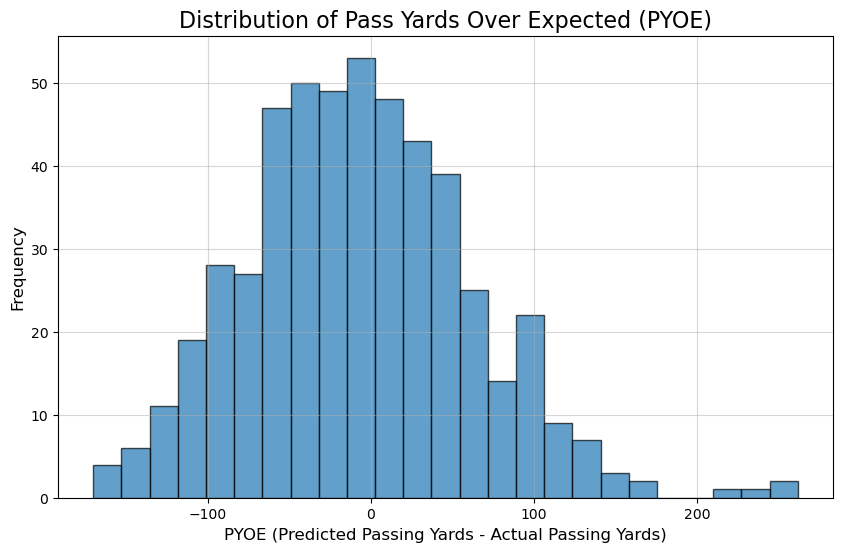

In [66]:
# Plotting the histogram of PYOE
plt.figure(figsize=(10, 6))
plt.hist(test_data['pyoe'], bins=25, edgecolor='black', alpha=0.7)
plt.title('Distribution of Pass Yards Over Expected (PYOE)', fontsize=16)
plt.xlabel('PYOE (Predicted Passing Yards - Actual Passing Yards)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

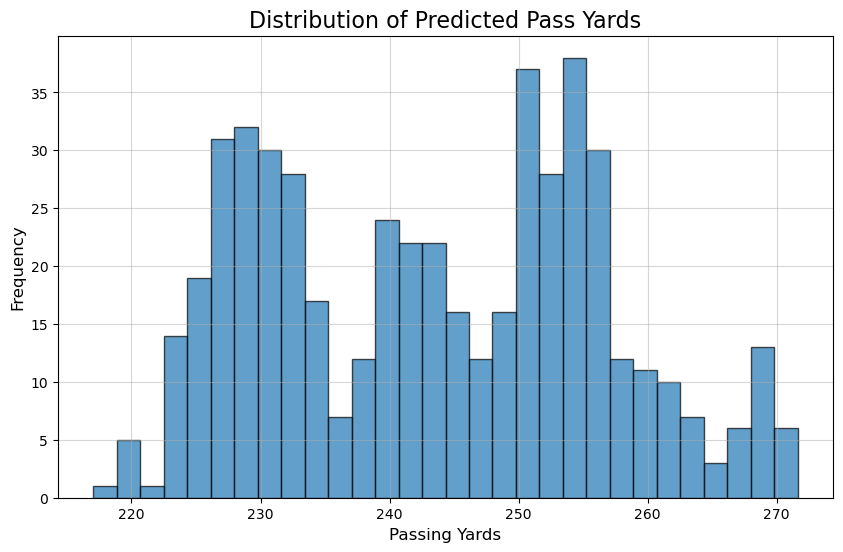

In [67]:
# Plotting the histogram of PYOE
plt.figure(figsize=(10, 6))
plt.hist(test_data['predicted_passing_yards'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Predicted Pass Yards', fontsize=16)
plt.xlabel('Passing Yards', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

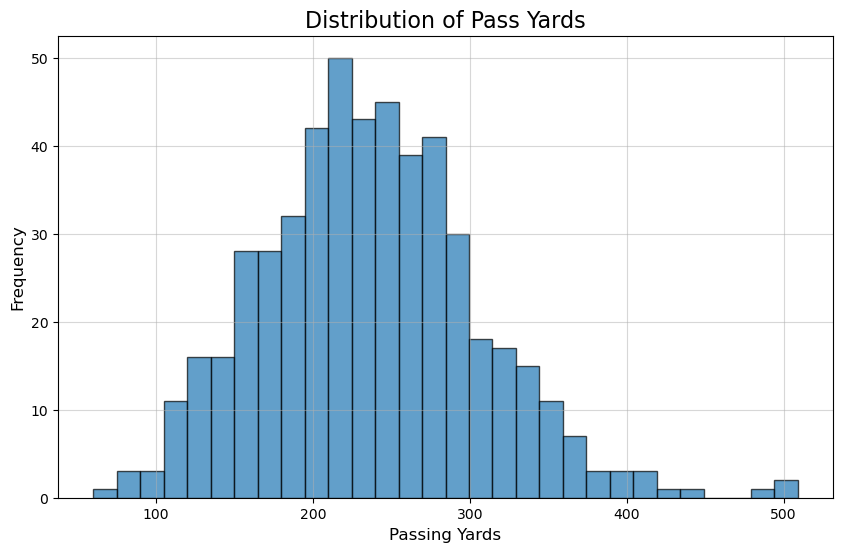

In [68]:
# Plotting the histogram of Pass Yards
plt.figure(figsize=(10, 6))
plt.hist(test_data['passing_yards'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Pass Yards', fontsize=16)
plt.xlabel('Passing Yards', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

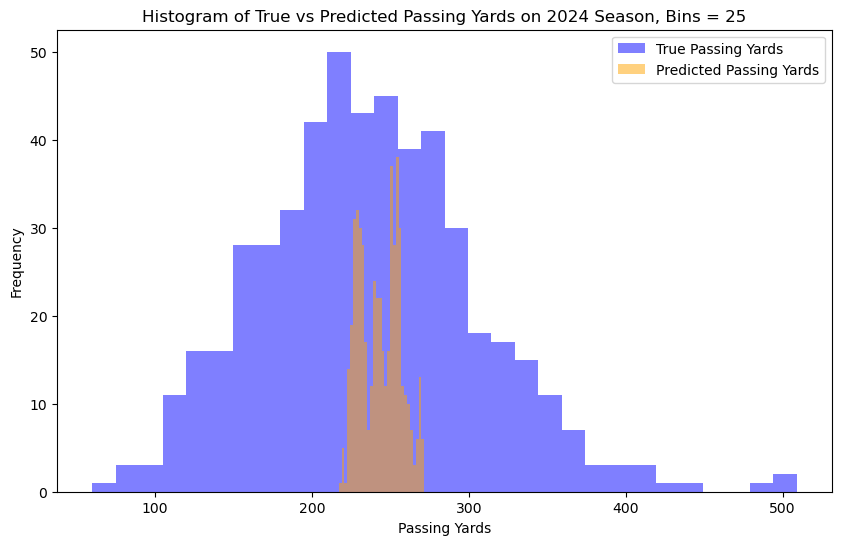

In [70]:
# Plotting the histogram of predicted passing yards and true passing yards
plt.figure(figsize=(10, 6))

# Plot histogram for true passing yards
plt.hist(test_data['passing_yards'], bins=30, alpha=0.5, label='True Passing Yards', color='blue')

# Plot histogram for predicted passing yards
plt.hist(test_data['predicted_passing_yards'], bins=30, alpha=0.5, label='Predicted Passing Yards', color='orange')

# Adding labels and title
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of True vs Predicted Passing Yards on 2024 Season, Bins = 25')
plt.legend(loc='upper right')

# Show the plot
plt.show()

below checks a qb's simulator prediction with a bootstrapped curve that is custom to that team's own passing variance this year. rad

In [ ]:
# # Example: Visualize Some QB's simulated passing yard

# #Put a starting QB In here to view the bootstrapped dist monte carlo simulation output
# simulations = qb_simulations['P.Mahomes']

# # Example: Visualize Kyler Murray's simulated passing yards using KDE plot
# plt.figure(figsize=(10, 6))
# sns.kdeplot(simulations, fill=True)

# # Add titles and labels
# plt.title("KDE of Simulated Passing Yards for Patrick Mahomes", fontsize=14)
# plt.xlabel("Passing Yards", fontsize=12)
# plt.ylabel("Density", fontsize=12)

# # Show the plot

# plt.show()

KeyError: 'P.Mahomes'

## To do:
* Figure out wtm is when there is a new qb/injury
* Find a way to tone down overpredictions (seems to be a weird trend this season people passing for less yards)
* Week 1 stuff for next season
* Write predictions to some sort of database for front end use? (ask pals with better knowledge on usable coding skills)